### To do list: Identify the source of the problem
1. Use exactly the same pair of MR,CBCT of runze's test set and see if new deforamtion works well on Runze's weight
2. If 1 is bad, swap the process of Deforam and Resize, and do it again to see if order is the key
3. Evaluate Runze's data under my new-trained weight

In [1]:
from layers import VecInt
from scipy.ndimage import distance_transform_edt as bwdist

class SourceWarpPoint:
    def __init__(self, point, decay_power=1, deformation_magnitude=6):

        # Default values
        self.decay_power = decay_power
        self.deformation_magnitude = deformation_magnitude
        self.point = point

    def print(self):
        print('point: ', self.point, ' decay power: ', self.decay_power,
              ' deformation magnitude: ', self.deformation_magnitude)


class SourceGen:
    """
    Randomly generate source points with:
    n_points: number of source points to drive deformation
    random decay power: min and max value
    deformation magnitude: min and max value
    Source points are randomly located with a given mask (e.g ventricle)
    """
    def __init__(self, n_points, image_shape, decay_power_range=[0.5, 2], deformation_magnitude_range=[1, 5]):
        self.n_points = n_points
        self.image_shape = image_shape
        self.decay_power_range = decay_power_range
        self.deformation_magnitude_range = deformation_magnitude_range

    def run(self, ventricle_mask=None):
        points = []
        sources = []

        if ventricle_mask is None:
            x, y, z = np.meshgrid(np.linspace(0, self.image_shape[0]-1, self.image_shape[0]),
                                  np.linspace(0, self.image_shape[1]-1, self.image_shape[1]),
                                  np.linspace(0, self.image_shape[2]-1, self.image_shape[2]))
        else:
            islice = np.argmax(np.sum(ventricle_mask > 0, axis=(0, 1)))  # find the slice with the largest masked volume
            mask_center = np.zeros(ventricle_mask.shape)
            mask_center[:, :, islice-5:islice+4] = ventricle_mask[:, :, islice - 5:islice + 4]  # only place sources around ±5 slices from islice
            x, y, z = np.where(mask_center > 0)

        index = np.random.randint(len(x), size=self.n_points)
        for i in range(self.n_points):
            points.append([x[index[i]], y[index[i]], z[index[i]]])
            alpha = np.random.uniform(low=self.deformation_magnitude_range[0], high=self.deformation_magnitude_range[1])
            beta_exp = np.random.uniform(low=np.log(self.decay_power_range[0]),
                                         high=np.log(np.minimum(self.decay_power_range[1], np.log2(alpha/(alpha-1)))))
            beta = np.exp(beta_exp)

            sources.append(SourceWarpPoint(point=points[i], decay_power=beta,
                                           deformation_magnitude=alpha*np.random.choice([-1, 1])))
        return sources


class Simulator:
    """
    Simulate a random deformation field based on source model D=a/r^b from multiple source points.

    Returns
    -------
    D : the overall deformation field

    """

    def __init__(self, image_size=[192, 240, 192], int_steps=7):

        self._image_size = image_size
        # self.transformer = SpatialTransformer(image_size, mode=interp_method)
        self.vectint = VecInt(image_size, int_steps)  # square and scaling layer for exponentiation

    def simulate(self, sources, brain_mask=None, thresh=30):
        """
        sources: sources to drive deformation, generated from SourceGen
        brain_mask: optional mask of the brain region, deformation outside is set to 0
        thresh: a threshold of the distance to the brain boundary (value above thresh is not affected)
        """
        [X, Y, Z] = np.mgrid[0:self._image_size[0], 0:self._image_size[1], 0:self._image_size[2]]
        D = np.zeros((3, self._image_size[0], self._image_size[1], self._image_size[2]))

        for source in sources:
            decay_power = source.decay_power
            deformation_mag = source.deformation_magnitude

            R2 = np.square(X-source.point[0]) + np.square(Y-source.point[1]) + np.square(Z-source.point[2])

            F = deformation_mag/(np.power(R2, decay_power/2)+1e-6) # deformation magnitude (+retraction,-dilation)
            F[source.point[0], source.point[1], source.point[2]] = deformation_mag

            DX = (X-source.point[0])/(np.sqrt(R2)+1e-5)*F
            DY = (Y-source.point[1])/(np.sqrt(R2)+1e-5)*F
            DZ = (Z-source.point[2])/(np.sqrt(R2)+1e-5)*F

            D = D + np.stack((DX, DY, DZ), axis=0)

        if brain_mask is not None:  # set deformation outside the brain to 0 with smooth transitions
            brain_dist = bwdist(brain_mask) / thresh
            brain_dist[brain_dist > 1] = 1
            D = np.multiply(D, np.repeat(brain_dist[np.newaxis, :, :], 3, axis=0))

        D = self.vectint(torch.from_numpy(D).unsqueeze(0).float())
        return D




### Step 1: Methodology
1. Read Runze's test set, get his MR and CBCT
2. Cast my deformation on his MR and CBCT (beta~U[5e-2,3e-1],alpha~U[1.5,4])
3. Check Runze's JSR performance on this data and see if extremely bad example exists

### Loading Runze's data
The data was resized to 128x160x128

In [2]:
import nibabel as nib
import torch
import numpy as np
import pandas as pd
from dataloader import RadOncTrainingDataset, RadOncValidationDataset, RadOncSynthesisDataset, headscanner_training_dataset, headscanner_validation_dataset
import matplotlib.pyplot as plt
from skimage.transform import resize

# test_path_r = "/mnt/blackhole-data2/RadOnc_Brain/NonRigid_Training_CBCT"
test_path_r = "/mnt/blackhole-data2/RadOnc_Brain/Validation"
mr_list = []
ct_list = []
cbct_list = []
mask_list = []
mask_brain_list = []
for i in range(10):
    name = f'/{i:03}.npz'
    data = np.load(test_path_r+name)
    cbct_list.append(resize(data['cbct'], [128,160,128], order=0, anti_aliasing=False))
    mr_list.append(resize(data['moving_truth'], [128,160,128], order=0, anti_aliasing=False))
    ct_list.append(resize(data['fixed_img'], [128,160,128], order=0, anti_aliasing=False))
    mask_list.append(resize(data['ventricle_fixed'], [128,160,128], order=0, anti_aliasing=False))
    mask_brain_list.append((ct_list[-1]>0).astype(int))
    


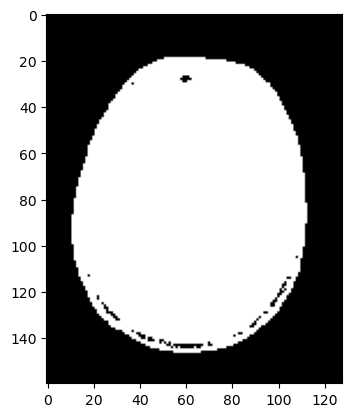

In [3]:
import matplotlib.pyplot as plt
plt.imshow(mask_brain_list[0][:,:,72].T,cmap = 'gray')

### Deformation
$\alpha:U[1.5,4]$
$\beta:U[5e^{-2},3e^{-1}]$


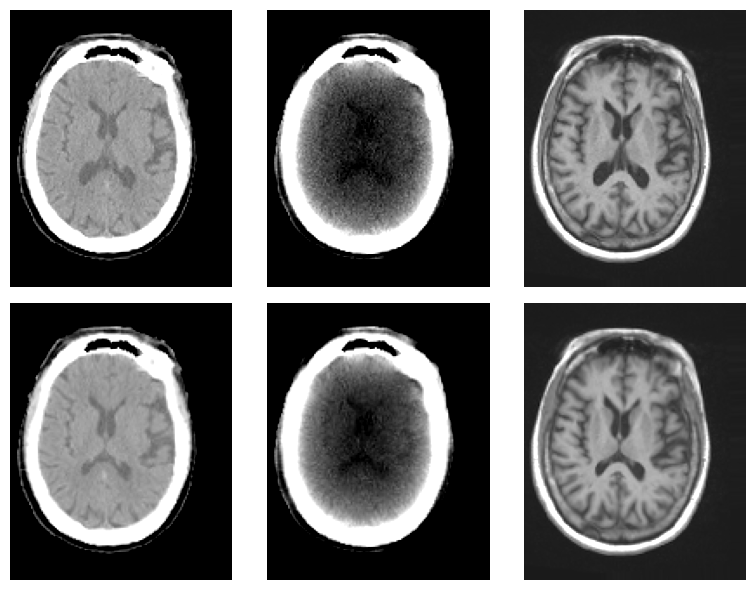

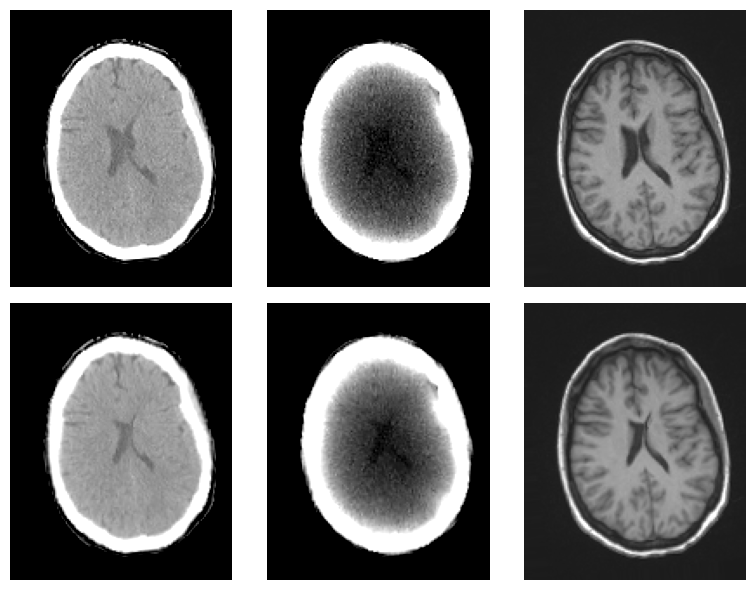

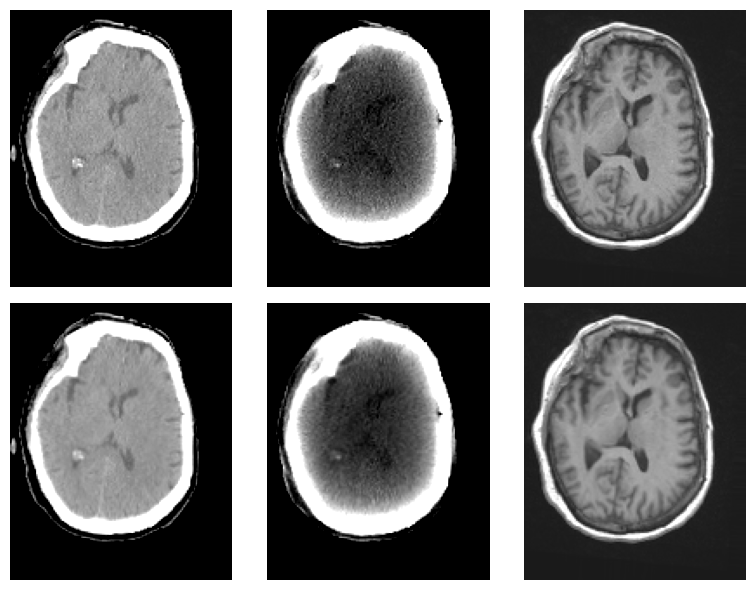

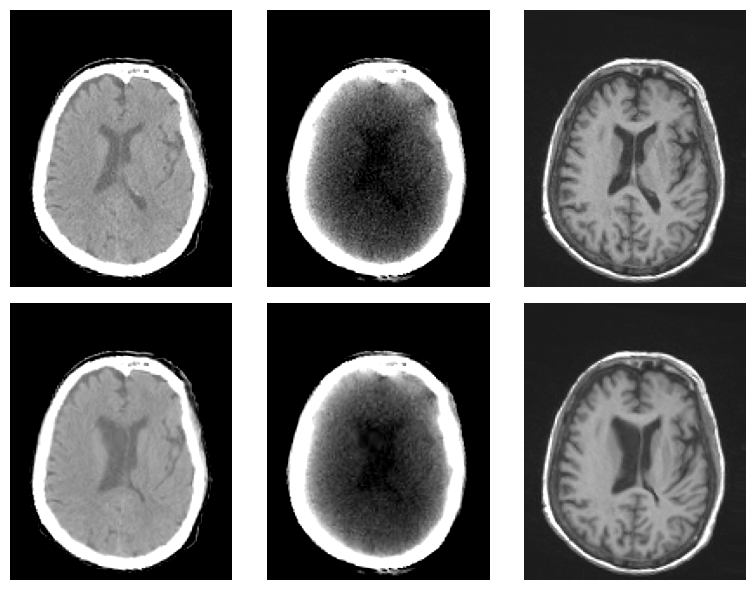

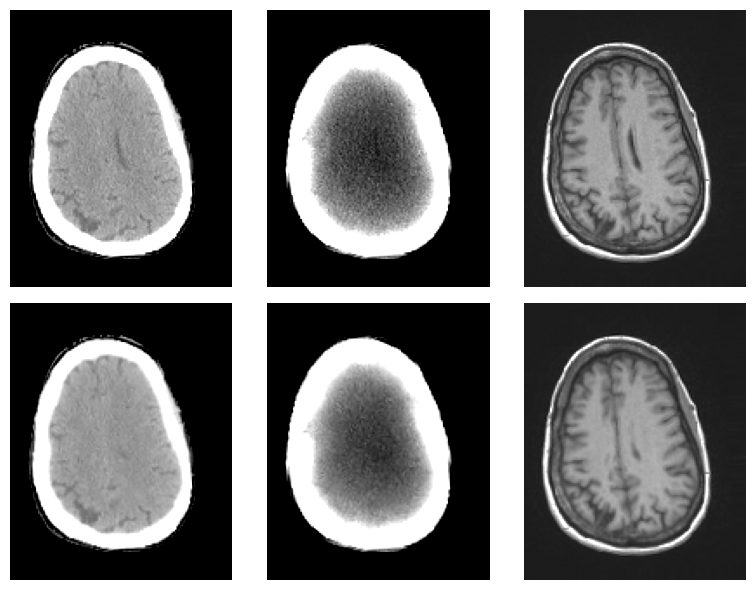

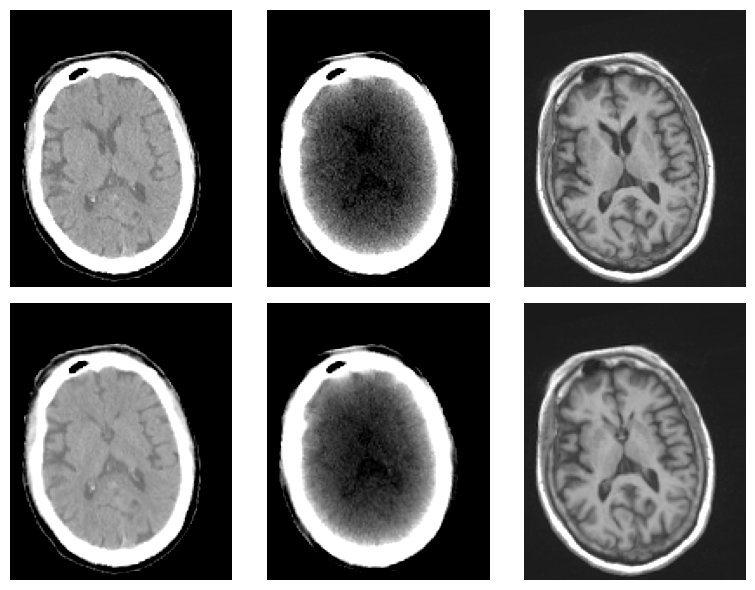

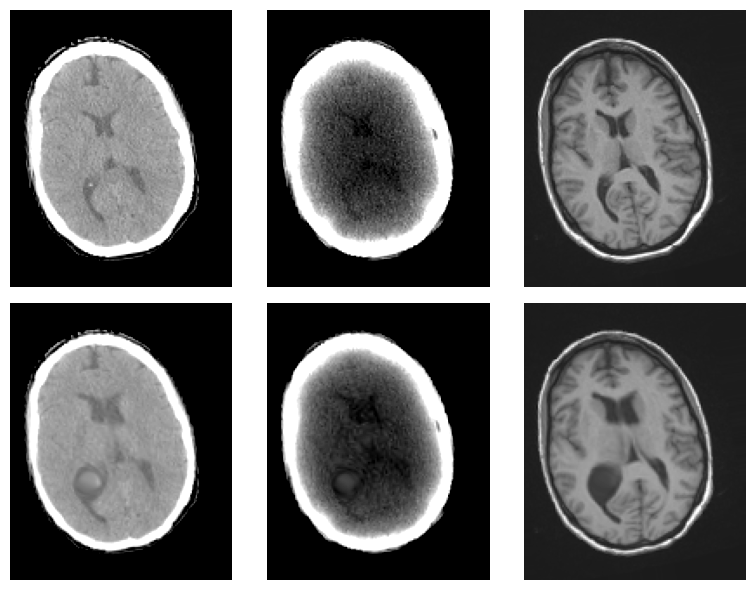

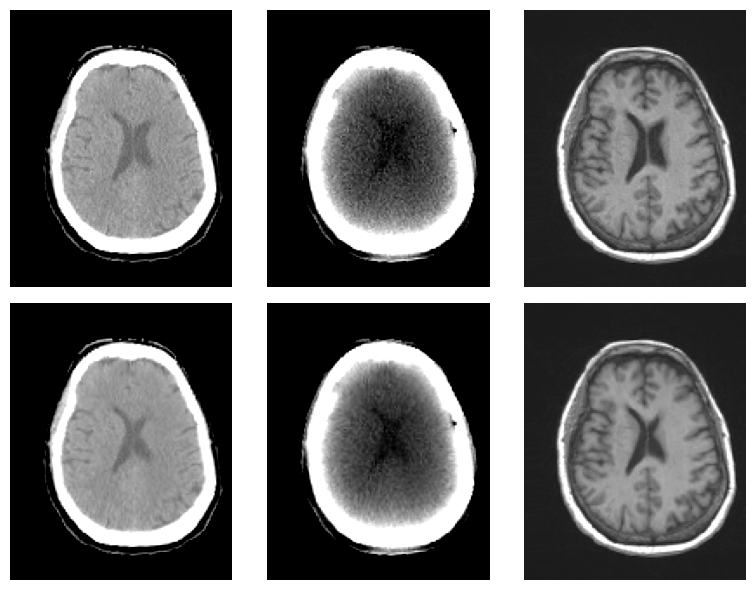

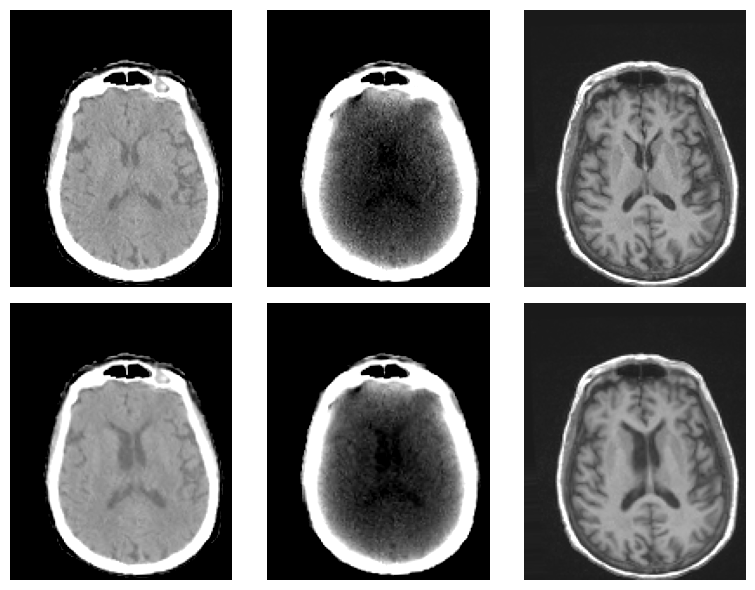

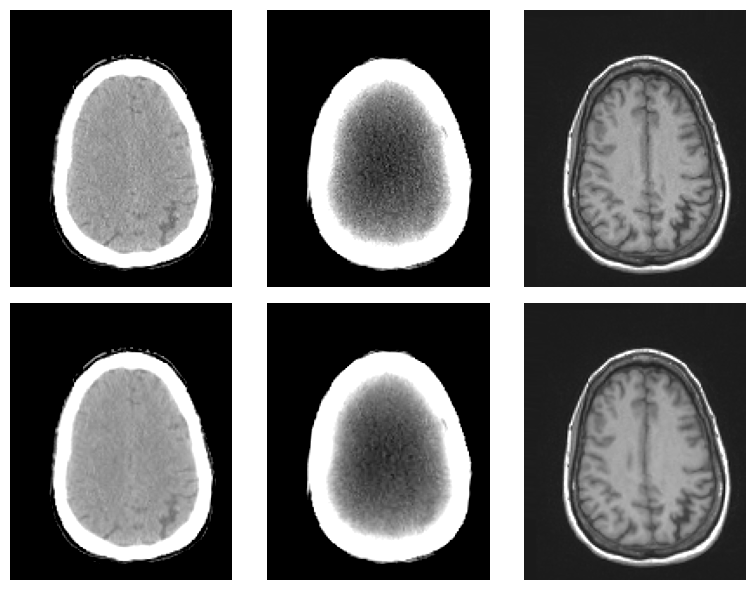

In [6]:
from layers import SpatialTransformer
from scipy.ndimage.interpolation import affine_transform
from helpers import normalizeImage, random_transform


config = dict()
config['image_size'] = [128, 160, 128]
config['augment_translation'] = 10
config['augment_rotation'] = 10
config['augment_n_points'] = [1, 5]  # number of points in deformation simulation
config['augment_decay_power_range'] = [5e-2, 3e-1]  # [1e-2,1e-1] # decay power range in deformation simulation
config['augment_deformation_range'] = [1.4, 4]  # deformation magnitude range in deformation simulation

original_shape = config['image_size']
transformer_linear = SpatialTransformer(original_shape, mode='bilinear')
transformer_nearest = SpatialTransformer(original_shape, mode='nearest')

mr_input = []
mr_gt = []
cbct_input = []
mask_input = []
mask_gt = []
ct_input = []
ct_gt = []

for index in range(10):
    ct = ct_list[index]
    mr = mr_list[index]
    cbct = cbct_list[index]
    mask_ventricle = mask_list[index]
    mask_brain = mask_brain_list[index]
    
    T = random_transform(list(np.shape(mr)), config['augment_translation'], config['augment_rotation'])
    ct = affine_transform(ct, T, mode='nearest')
    mr = affine_transform(mr, T, mode='nearest')
    cbct = affine_transform(cbct, T, mode='nearest')
    mask_ventricle = affine_transform(mask_ventricle, T, mode='nearest', order=0)
    mask_brain = affine_transform(mask_brain, T, mode='nearest', order=0)

    # Simulate deformations
    n_points = np.random.randint(config['augment_n_points'][0], config['augment_n_points'][1])
    source_gen = SourceGen(n_points, original_shape, decay_power_range=config['augment_decay_power_range'],
                           deformation_magnitude_range=config['augment_deformation_range'])
    sources = source_gen.run(ventricle_mask=(mask_ventricle == 23) + (mask_ventricle == 24))
    sim = Simulator(original_shape)
    flow = sim.simulate(sources, mask_brain)

    # Apply deformations
    ct = torch.from_numpy(ct).unsqueeze(0).unsqueeze(0).float()
    ct_deform = transformer_linear(ct, flow)
    mr = torch.from_numpy(mr).unsqueeze(0).unsqueeze(0).float()
    mr_deform = transformer_linear(mr, flow)
    cbct = torch.from_numpy(cbct).unsqueeze(0).unsqueeze(0).float()
    cbct_deform = transformer_linear(cbct, flow)
    mask = torch.from_numpy(mask_ventricle).unsqueeze(0).unsqueeze(0).float()
    mask_deform = transformer_nearest(mask, flow)
    
    mr_input.append(mr_deform)
    mr_gt.append(mr)
    cbct_input.append(cbct)
    ct_input.append(ct_deform)
    ct_gt.append(ct)
    mask_input.append(mask_deform)
    mask_gt.append(mask)
    
    islice = 68
    fig, ax = plt.subplots(2,3,figsize=(8,6))
    np.vectorize(lambda ax: ax.axis('off'))(ax)
    ax[0, 0].imshow(ct[0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
    ax[1, 0].imshow(ct_deform[0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
    ax[0, 1].imshow(cbct[0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
    ax[1, 1].imshow(cbct_deform[0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
    ax[0, 2].imshow(mr[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
    ax[1, 2].imshow(mr_deform[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
    plt.tight_layout()
    plt.show()


    

In [5]:
import networks_gan
device = 'cpu'
G = networks_gan.JSRCascade(separate_decoders=True, res=True, version='v3').to(device)
checkpoint = torch.load('JSRCascade_l1100_multi0.3_reg100_seg0_ep109.pt', map_location=torch.device('cpu'))
G.load_state_dict(checkpoint['G_state_dict'])

<All keys matched successfully>

  0%|          | 0/10 [00:00<?, ?it/s]

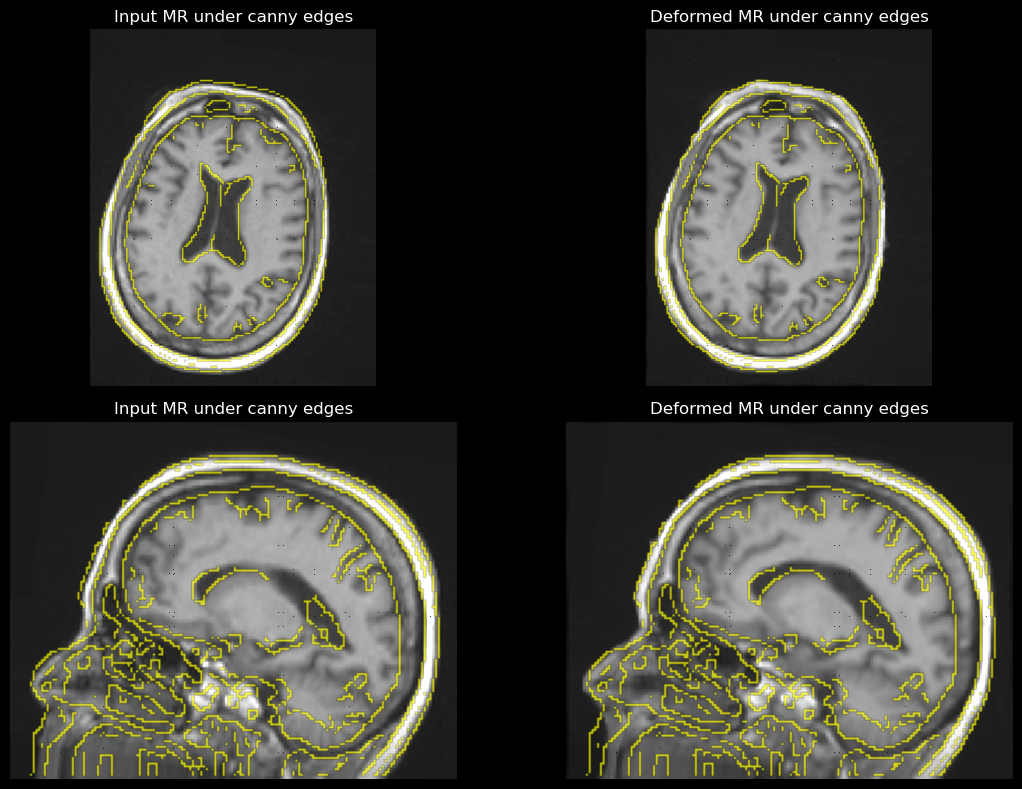

  0%|          | 0/10 [00:08<?, ?it/s]


ValueError: The arguments must be of compatible shape. Got mask_gt with 4 dimensions ((0, 128, 160, 128)) and mask_pred with 4 dimensions ((0, 128, 160, 128)), while the spacing_mm was 3 elements.

In [6]:
from tqdm import tqdm
import networks_gan
from layers import SpatialTransformer
from skimage.feature import canny
from matplotlib import colors as mplcolors
from helpers import compute_surface_metrics, compute_TRE
import losses
import os
import glob

def colormap_binary(fg, bg=(0,0,0), alpha=None):
    fg = mplcolors.to_rgb(fg)
    bg = mplcolors.to_rgb(bg)
    cmap = mplcolors.LinearSegmentedColormap.from_list('Binary', (bg,fg), 256)
    if alpha is not None:
        cmap._init()
        cmap._lut[:,-1] = np.linspace(0, alpha, cmap.N+3)
    return cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')

metrics = pd.DataFrame()
mask_val = [1,2,23,5,19,29,8]

for ep in range(1):
    G.load_state_dict(checkpoint['G_state_dict'])
    dice_before_total = []
    dice_after_total = []
    hd_before_total = []
    sd_before_total = []
    hd_after_total = []
    
    sd_after_total = []
    tre_before_total = []
    tre_after_total = []
    
    for i in tqdm(range(10)):
        cbct_fixed = cbct_input[i].float().to(device)
        mr_moving = mr_input[i].float().to(device)
        seg_fixed =mask_gt[i].float().to(device)
        seg_moving = mask_input[i].float().to(device)
        ct_fixed = ct_gt[i].float().to(device)
        
        islice = 70
        islice_s = 68
        with torch.no_grad():
            flow, ct_moving_synth, ct_fixed_synth= G(mr_moving, cbct_fixed)
            
            mr_reg = SpatialTransformer([128,160,128], mode='bilinear').to(device)(mr_moving, flow[0])
            ct_reg_synth = SpatialTransformer([128,160,128], mode='bilinear').to(device)(ct_moving_synth[0], flow[0])
            seg_reg =SpatialTransformer([128,160,128], mode='nearest').to(device)(seg_moving, flow[0])
            
            fig, ax = plt.subplots(2,2,figsize=(12,8))
            np.vectorize(lambda ax: ax.axis('off'))(ax)
            
            ax[0, 0].imshow(mr_moving[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
            ax[0, 0].imshow(canny(ct_fixed.cpu().numpy()[0,0,:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[0, 0].set_title('Input MR under canny edges')
            
            ax[0, 1].imshow(mr_reg[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
            ax[0, 1].imshow(canny(ct_fixed.cpu().numpy()[0,0,:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[0, 1].set_title('Deformed MR under canny edges')
            
            ax[1, 0].imshow(torch.flipud(mr_moving[0,0,islice_s,:,:].T), cmap='gray', vmin=0, vmax=0.4)
            ax[1, 0].imshow(np.flipud(canny(ct_fixed.cpu().numpy()[0,0,islice,:,:].T, sigma=1)), cmap=colormap_binary('yellow', alpha=0.7))
            ax[1, 0].set_title('Input MR under canny edges')
            
            ax[1, 1].imshow(torch.flipud(mr_reg[0,0,islice_s,:,:].T), cmap='gray', vmin=0, vmax=0.4)
            ax[1, 1].imshow(np.flipud(canny(ct_fixed.cpu().numpy()[0,0,islice,:,:].T, sigma=1)), cmap=colormap_binary('yellow', alpha=0.7))
            ax[1, 1].set_title('Deformed MR under canny edges')     

            plt.tight_layout()
            plt.show()
                   
            dice_before = []
            hd_before = []
            sd_before = []
            dice_after= []
            hd_after = []
            sd_after = []
            for j, val in enumerate(mask_val):
                mask_fixed = seg_fixed[:,j:j+1,:,:,:]
                mask_moving = seg_moving[:,j:j+1,:,:,:]
                mask_registered = seg_reg[:,j:j+1,:,:,:]
                dice_before.append(-losses.Dice().loss(mask_fixed,mask_moving).item())
                dice_after.append(-losses.Dice().loss(mask_fixed,mask_registered).item())
                metrics_before = compute_surface_metrics(np.squeeze(mask_fixed.squeeze().cpu().numpy())==1, np.squeeze(mask_moving.squeeze().cpu().numpy())==1)
                metrics_after = compute_surface_metrics(np.squeeze(mask_fixed.squeeze().cpu().numpy())==1, np.squeeze(mask_registered.squeeze().cpu().numpy())==1)
                hd_before.append(metrics_before['hd'])
                hd_after.append(metrics_after['hd'])
                sd_before.append(metrics_before['avg_dist'])
                sd_after.append(metrics_after['avg_dist'])
                
            valid_ds = np.load(glob.glob(os.path.join("/mnt/blackhole-data2/RadOnc_Brain/Validation",'*.npz'))[i])
            seg_fixed = valid_ds['ventricle_fixed']
            seg_moving = valid_ds['ventricle_moving']
            seg_fixed = torch.from_numpy(resize(seg_fixed, [128,160,128], order=0, anti_aliasing=False)).unsqueeze(0).unsqueeze(0).to(device)
            seg_moving = torch.from_numpy(resize(seg_moving, [128,160,128], order=0, anti_aliasing=False)).unsqueeze(0).unsqueeze(0).to(device)
            seg_reg = SpatialTransformer([128,160,128], mode='nearest').to(device)(seg_moving, flow[0])
            tre_before_total.append(compute_TRE(seg_fixed.squeeze().cpu().numpy(), seg_moving.squeeze().cpu().numpy(), [1,1,1]).mean())
            tre_after_total.append(compute_TRE(seg_fixed.squeeze().cpu().numpy(), seg_reg.squeeze().cpu().numpy(), [1,1,1]).mean())
            dice_before_total.append(dice_before)
            dice_after_total.append(dice_after)
            hd_before_total.append(hd_before)
            hd_after_total.append(hd_after)
            sd_before_total.append(sd_before)
            sd_after_total.append(sd_after)
    if ep == 0:
        d0 = {'Dice':np.reshape(np.array(dice_before_total),-1), 'HD':np.reshape(np.array(hd_before_total),-1), 'SD':np.reshape(np.array(sd_before_total),-1), 
              'anatomy':['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']*10, 'ep':[0]*70, 'method':['Rigid']*70}
        d0 = pd.DataFrame(data=d0)
        metrics = pd.concat([metrics, d0])

    d = {'Dice':np.reshape(np.array(dice_after_total),-1), 'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1), 
         'anatomy':['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']*10, 'ep':[29+ep*10]*70, 'method':['JSR-Cascade']*70}
    d = pd.DataFrame(data=d)
    metrics = pd.concat([metrics, d])

   

In [11]:
plt.imshow(mask_fixed[0,0,:,:,72].T)

IndexError: index 0 is out of bounds for dimension 1 with size 0

In [12]:
mask_fixed.shape

torch.Size([1, 0, 128, 160, 128])